# Element Parameter Detection

## Setup

In [1]:
%load_ext autoreload

import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch
from numpy.random import default_rng
from tqdm.notebook import tqdm
from ipywidgets import interact 
import gc

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src.preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance, get_oriented_bbox_from_points
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune, mahalanobis_fine_tune
from src.cloud import add_noise


random.seed = 42
rng = default_rng()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loaded JIT 3D CUDA emd


### sphere morphing

In [ ]:
# visualise a list of point clouds as an animation using open3d
# use ctrl+c to copy and ctrl+v to set camera and zoom inside visualiser
def create_point_cloud_animation(cloud_list, loss_func, save_image=False, colours=None):
    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Debug)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    cloud = cloud_list[0]
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(cloud)
    if colours is not None:
        point_cloud.colors = o3d.utility.Vector3dVector(colours[0])
    vis.add_geometry(point_cloud)
    stops = [9,39,99,299,999]

    for i in range(len(cloud_list)):
        time.sleep(0.01 + 0.05/(i/10+1))
        cloud = cloud_list[i]
        point_cloud.points = o3d.utility.Vector3dVector(cloud)
        if colours is not None:
            point_cloud.colors = o3d.utility.Vector3dVector(colours[i])
        vis.update_geometry(point_cloud)
        vis.poll_events()
        vis.update_renderer()
        if save_image and i in stops:
            vis.capture_screen_image("sphere/" + loss_func + str(i) + ".jpg", do_render=True)
    vis.destroy_window()

    o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Info)


In [ ]:
def calc_direct(x, y):
    return torch.sum(torch.square(x-y))

In [ ]:
%autoreload 2

# morph a sphere into the shape of an input point cloud
# by optimising chamfer loss iteratively
# total points = num_points**2
def morph_sphere(src_pcd_tensor, num_points, iterations, learning_rate, stops=[],
                 loss_func= "chamfer", measure_consistency=True, sphere=True, return_assignment=True):
    
    cuda = torch.device("cuda")
    if sphere:
        # gnerate sphere
        # Generate spherical coordinates
        theta = np.linspace(0, 2 * np.pi, num_points)
        phi = np.linspace(0, np.pi, num_points)

        # Create a meshgrid from spherical coordinates
        theta, phi = np.meshgrid(theta, phi)

        # Convert spherical coordinates to Cartesian coordinates
        x = np.sin(phi) * np.cos(theta)
        y = np.sin(phi) * np.sin(theta)
        z = np.cos(phi)

        # Stack the coordinates to form a 3D point cloud and reshape to (num_points * num_points, 3)
        sphere_points = np.stack([x, y, z], axis=-1).reshape(-1, 3)
        sphere_points = np.array([sphere_points for i in range(len(src_pcd_tensor))])
        sphere_points = torch.tensor(sphere_points, device=cuda, 
                                     requires_grad=True)
    else:
        sphere_points = torch.rand(1, num_points**2, 3, device=cuda, 
                                   dtype=torch.double, requires_grad=True)
    
    # optimise
    optimizer = torch.optim.Adam([sphere_points], lr=learning_rate)
    intermediate, losses, assingments = [], [], []
    chamferDist = ChamferDistance()
    assignments = []

    for i in tqdm(range(iterations)):
        optimizer.zero_grad()
        
        if loss_func == "chamfer":
            nn = chamferDist(
                src_pcd_tensor, sphere_points, bidirectional=True, return_nn=True)
            loss = torch.sum(nn[1].dists) + torch.sum(nn[0].dists)
            assignment = [nn[0].idx[:,:,0].detach().cpu().numpy(), nn[1].idx[:,:,0].detach().cpu().numpy()]
        elif loss_func == "emd":
            loss, assignment = calc_emd(sphere_points, src_pcd_tensor, 0.05, 50)
            assignment = assignment.detach().cpu().numpy()
        elif loss_func == "direct":
            loss = calc_direct(sphere_points, src_pcd_tensor)
            assignment = None
        elif loss_func == "pair":
            loss, assignment = get_pair_loss_clouds_tensor(src_pcd_tensor, sphere_points, add_pair_loss=True, it=i)
        elif loss_func == "jittery":
            loss = get_jittery_cd_tensor(src_pcd_tensor, sphere_points, k=1, it=i)
        elif loss_func == "self":
            loss = get_self_cd_tensor(src_pcd_tensor, sphere_points)
        elif loss_func == "reverse":
            loss, assignment = calc_reverse_weighted_cd_tensor(src_pcd_tensor, sphere_points, return_assignment=True, k=32)
        elif loss_func == "prob":
            loss, assignment = calc_pairing_probabilty_loss_tensor(src_pcd_tensor, sphere_points, k=64)
        elif loss_func == "balanced":
            loss, assignment = calc_balanced_chamfer_loss_tensor(src_pcd_tensor, sphere_points, return_assignment=True, k=32)
        elif loss_func == "single":
            loss, assignment = calc_balanced_single_chamfer_loss_tensor(src_pcd_tensor, sphere_points, return_assignment=True, k=32)
        elif loss_func == "infocd":
            loss, assignment = calc_cd_like_InfoV2(src_pcd_tensor, sphere_points, return_assignment=True)
        else:
            print("unspecified loss")
            
        #print("a", assignment[0].shape)
        loss.backward()
        optimizer.step()
        #print("iteration", i, "loss", loss.item())
        
        if i in stops:
            intermediate.append(sphere_points.clone())
            losses.append(loss.item())
            if measure_consistency:
                assignments.append(assignment)
            
    # calculate final chamfer loss
    dist = chamferDist(
                src_pcd_tensor, sphere_points, bidirectional=True)
    emd_loss, _ = calc_emd(sphere_points, src_pcd_tensor, 0.05, 50)
    print("final chamfer dist", dist.item(), "emd", emd_loss.item())
    
    # save assignments for analysis
#     if measure_consistency:
#         with open("sphere/assignments_" + loss_func + ".pkl", "wb") as f:
#             pickle.dump(assingments, f)
            
    intermediate = torch.stack(intermediate)
    if return_assignment:
        assignments = assignments
        return intermediate, losses, assignments
    return intermediate, losses

In [5]:
def run_morph(cld1_name, loss_func):
    cuda = torch.device("cuda")
    cld1 = np.array(o3d.io.read_point_cloud(cld1_name).points)
    src_pcd_tensor = torch.tensor([cld1], device=cuda)

    iterations = 1000
    #stops = [0, 10, 50, 100, 150, 500, 999]
    stops = [i for i in range(0,iterations,2)]

    morphed, losses = morph_sphere(src_pcd_tensor, 64, iterations, 0.01, stops, loss_func=loss_func)
    morphed = torch.flatten(morphed, start_dim=1, end_dim=2)
    morphed = morphed.cpu().detach().numpy()
    #print(morphed.shape)

    # save frames
    with open("sphere/" + loss_func + ".pkl", "wb") as f:
        pickle.dump(morphed, f)

    with open("sphere/loss_" + loss_func + ".pkl", "wb") as f:
        pickle.dump(losses, f)

    # Save the PointCloud to a PCD file
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(morphed[-1])
    o3d.io.write_point_cloud("sphere/sphere_" + loss_func + ".pcd", point_cloud)

In [6]:
# cld1_name = "sphere/chair.pcd"
# loss_func = "chamfer"
# run_morph(cld1_name, loss_func)

In [ ]:
%autoreload 2

# visualise animation
cld1_name = "sphere/plane1.pcd"
visualise = True
#loss_funcs = [ "chamfer", "emd", "balanced", "reverse", "single"]
#loss_funcs = [ "balanced", "single"]
loss_funcs = [ "balanced"]
for loss_func in loss_funcs:
    print(loss_func)
    run_morph(cld1_name, loss_func)
    if visualise:
        with open("sphere/" + loss_func + ".pkl", "rb") as f:
            morphed = pickle.load(f)
        colours = visualise_density(morphed, 'plasma_r')
        with open("sphere/" + loss_func + "_dens.pkl", "wb") as f:
            pickle.dump(colours, f)
        #create_point_cloud_animation(cloud_list, loss_func)
    torch.cuda.empty_cache()
    gc.collect()

balanced


In [ ]:
def view_density(loss_func): 
    with open("sphere/" + loss_func + ".pkl", "rb") as f:
        morphed = pickle.load(f)
    with open("sphere/" + loss_func + "_dens.pkl", "rb") as f:
        colours = pickle.load(f)

    create_point_cloud_animation(morphed, loss_func, True, colours[:,:,:3])
    
interact(view_density, loss_func=[ "balanced", "infocd", "single", "chamfer", "reverse", "emd", "direct"]); 


In [ ]:
torch.cuda.empty_cache()
gc.collect()

# visualise animation
loss_func = "emd"
with open("sphere/" + loss_func + ".pkl", "rb") as f:
    morphed = pickle.load(f)
print(morphed.shape, loss_func)
cloud_list = [m for m in morphed]
#create_point_cloud_animation(cloud_list, loss_func)


In [ ]:
colours = visualise_density(morphed, 'plasma_r')
with open("sphere/" + loss_func + "_dens.pkl", "wb") as f:
    pickle.dump(colours, f)

### Batch optimisation

In [6]:
# batch sphere optimisation (for metrics)

def sphere_morph_metrics(loss_func, shapenet_path):
    # load shapenet test dataset
    folders = os.listdir(shapenet_path)
    print(loss_func)
    cuda = torch.device("cuda")
    chamferDist = ChamferDistance()

    iterations = 1001
    stops = [i for i in range(0,1001,10)]
    chamfer_results = np.zeros(len(stops))
    emd_results = np.zeros(len(stops))
    count = 0
    assignments_folders = []
    
    for fl in folders:
        files = os.listdir(shapenet_path + fl)
        clouds = []
        for cl in files:
            clouds.append(np.array(o3d.io.read_point_cloud(shapenet_path + fl + "/" + cl).points))
        clouds = np.array(clouds)
        clouds = torch.tensor(clouds, device=cuda)
        count += len(clouds)
        #print(clouds.shape)

        # optimise spheres and gather intermediate clouds
        
        morphed, losses, assignments = morph_sphere(clouds, 64, iterations, 0.01, stops, loss_func=loss_func, 
                                       return_assignment=True)
        assignments_folders.append(assignments)

        #calculate chamfer and EMD
        print(morphed.shape)

        # loop through stops
        for i, mr in enumerate(tqdm(morphed)):
            nn = chamferDist(clouds, mr, bidirectional=True, return_nn=True)
            cd_loss = torch.sum(nn[1].dists) + torch.sum(nn[0].dists)
            #cd_assignment = [nn[0].idx[0,:,0].detach().cpu().numpy(), nn[1].idx[0,:,0].detach().cpu().numpy()]
            emd_loss, _ = calc_emd(clouds, mr, 0.05, 50)
            #emd_assignment = emd_assignment.detach().cpu().numpy()

            #print(cd_loss.item(), emd_loss.item())
#             cd_assignments_cat.append(cd_assignment)
#             emd_assignments_cat.append(emd_assignment)
            chamfer_results[i] += cd_loss
            emd_results[i] += emd_loss

        torch.cuda.empty_cache()
        gc.collect()
    
    print(count, chamfer_results[0])
    chamfer_results = chamfer_results/count
    emd_results = emd_results/count

    # save results
    with open("sphere/" + loss_func + "_metrics.pkl", "wb") as f:
        pickle.dump([chamfer_results, emd_results, assignments_folders], f)


In [7]:
# downsample
shapenet_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/ShapeNetCompletion/test/complete/"
downsampled_path = "/home/haritha/documents/experiments/ICCV2023-HyperCD/ShapeNetCompletion/downsample/"
# folders = os.listdir(shapenet_path)
# choices = np.random.choice(len(points), 4096)

# for fl in tqdm(folders):
#     if not os.path.exists(downsampled_path+fl):
#         os.mkdir(downsampled_path+fl)
        
#     files = os.listdir(shapenet_path + fl)
#     cloud =  o3d.geometry.PointCloud()
#     for cl in files:
#         points = np.array(o3d.io.read_point_cloud(shapenet_path + fl + "/" + cl).points)
#         points = points[choices]
#         cloud.points = o3d.utility.Vector3dVector(points)
#         o3d.io.write_point_cloud(downsampled_path+fl + "/" + cl, cloud)

In [ ]:
loss_func = "balanced"
loss_func = "balanced"

sphere_morph_metrics(loss_func, downsampled_path)

balanced


  0%|          | 0/1001 [00:00<?, ?it/s]

In [2]:
# helper function to recombine batched output from balancedCD
file_prefix = "sphere/balanced_metrics"
icd_chamfer_list, icd_emd_list, icd_assignment_list = [], [], []

for i in range(1,9):
    with open(file_prefix + str(i) + ".pkl", "rb") as f:
        chamfer, emd, ass = pickle.load(f)
        print(len(ass), len(ass[0]), len(ass[0][0]), ass[0][0][0].shape)
        icd_chamfer_list.append(chamfer)
        icd_emd_list.append(emd)
        icd_assignment_list.append(ass[0])

icd_assignment_list = np.array(icd_assignment_list)        
icd_assignment_list = np.transpose(icd_assignment_list, axes=(1,2,0,3,4))
icd_assignment_list = np.reshape(icd_assignment_list, (101, 2, 8*150, 4096))

1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)
1 101 2 (150, 4096)


In [3]:
balanced_cd = np.sum(np.array(icd_chamfer_list), axis=0)
balanced_emd = np.sum(np.array(icd_emd_list), axis=0)
print(balanced_emd.shape)

NameError: name 'infocd_cd' is not defined

In [7]:
# create plots
loss_funcs = ["infocd", "chamfer", "emd", "balanced"]
chamfer_list, emd_list = [], []
for loss_func in loss_funcs:
    if loss_func == "balanced":
        continue
    with open("sphere/" + loss_func + "_metrics.pkl", "rb") as f:
        chamfer, emd, _ = pickle.load(f)
        chamfer_list.append(chamfer)
        emd_list.append(emd)


In [9]:
if "balanced" in loss_funcs:
    chamfer_list.append(balanced_cd)
    emd_list.append(balanced_emd)

EMD infocd 0.7977625020345052 chamfer 0.6761717732747395 emd 0.0029214702049891153 BALANCED 0.48426786581675213
CD infocd 0.34422575409088113 chamfer 0.9137516937402139 emd 0.056225187202899096 balanced 0.5907473954542072


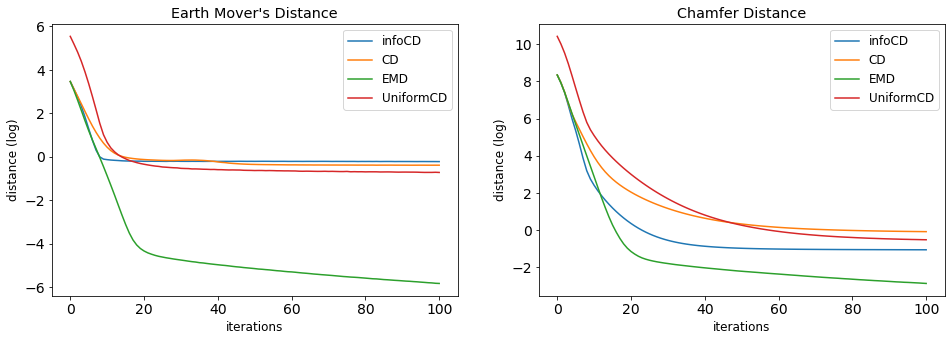

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
loss_funcs = ["infoCD", "CD", "EMD", "UniformCD"]

plot_dists(axes[1], chamfer_list, loss_funcs, "Chamfer Distance", "iterations", log=True)
plot_dists(axes[0], emd_list, loss_funcs, "Earth Mover's Distance", "iterations", log=True)
print("EMD infocd", emd_list[0][-1], "chamfer", emd_list[1][-1],  "emd", emd_list[2][-1], "BALANCED", emd_list[3][-1])
print("CD infocd", chamfer_list[0][-1], "chamfer", chamfer_list[1][-1], "emd", chamfer_list[2][-1], "balanced", chamfer_list[3][-1])


In [11]:
print(emd_list[1][0])

31.848079427083334


In [10]:
print(len(ass), len(ass[0]), len(ass[0][0]), ass[0][0][0].shape)

8 101 2 (4096,)


In [12]:
print(len(ass2), len(ass2[0]), len(ass2[0][0]), ass2[0][0][0].shape)

8 101 2 (150, 4096, 1)


In [40]:
# plot losses on same axis
def plot_dists(ax, losses, labels, title, xlabel="point cloud index", ylabel="distance (log)", log=True):
    x = np.arange(0, len(losses[0]))

#     # scale chamfer distance to be comparable with mahalanobis
#     max = []

#     mahal_dist_max = np.max(mahal_dist_sk)
#     chamfer_dist_max = np.max(chamfer_dist)
#     chamfer_dist = chamfer_dist / chamfer_dist_max * mahal_dist_max

    for i, loss in enumerate(losses):
        if log:
            ax.plot(x, np.log(loss), label=labels[i])
        else:
            ax.plot(x, loss, label=labels[i])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

In [ ]:
# load losses
# single, not batch
loss_types = ["reverse", "chamfer", "emd", "pair"]
losses = []

for loss_func in loss_types:
    with open("sphere/loss_" + loss_func + ".pkl", "rb") as f:
        losses.append(pickle.load(f))
        
plot_dists(losses, loss_types, "loss function comparison")


#### consistency

In [47]:
# measure conssistency between forward and backward correspondences for chamfer distance
# optionally compare against the ideal assignment, as measured by EMD
def measure_assignment_consistency(assignment, emd=None):
    reverse_assignment = torch.gather(assignment[0], 0, assignment[1])
    expected = torch.arange(assignment[0].shape[0], device=torch.device("cuda"))
    consistency = torch.sum(torch.eq(expected, reverse_assignment).long())
    print("consistency", consistency.item(), len(torch.unique(assignment[0])), len(torch.unique(assignment[1])))
    
    if emd is not None:
        #print(emd[:5], assignment[0][:5], assignment[1][:5])
        emd_consistency = torch.sum(torch.eq(emd, assignment[0]).long())
        #print("emd_consistency", emd_consistency.item(), len(torch.unique(emd)))


In [48]:
# measure conssistency between forward and backward correspondences for chamfer distance
# measure number of unique assignments
# measure rate of change of assignments
def measure_batch_assignment_consistency(assignment, loss):
    cuda = torch.device("cuda")
    # loop through iterations
    consistencies = []
    uniques = []
    changes = []
    for i in tqdm(range(len(assignment))):
        
        # check reverse consistency
        class_assignment = torch.tensor(assignment[i], device=cuda)
        reverse_assignment = torch.gather(class_assignment[0], 1, class_assignment[1])
        #print("r", reverse_assignment.shape)
        expected = torch.arange(class_assignment[0].shape[1], device=cuda)
        expected = expected.repeat(class_assignment[0].shape[0], 1)
        #print("e", expected.shape)
        consistency = torch.sum(torch.eq(expected, reverse_assignment).long())/len(class_assignment[0])
        consistencies.append(consistency.item())
        
        # check uniqueness of matches
        unique = 0
        for j in range(len(class_assignment[0])):
            unique += (len(torch.unique(class_assignment[0][j])) +
                       len(torch.unique(class_assignment[0][j])))
        unique = (unique/len(class_assignment[0]))/2
        uniques.append(unique)
        
        # check rate of change of matches
        if i==0:
            change = 0
        else:
            change = (assignment[i] == assignment[i-1]).sum()
            change = (change/len(class_assignment[0]))/2
        changes.append(change)
        
        print("un", unique, "consistency", consistency.item(), "change", change)

    
    # save results
    with open("sphere/" + loss + "_consistency.pkl", "wb") as f:
        pickle.dump([consistencies, uniques, changes], f)


In [40]:
# preprocess
loss = "infocd"
#ass = np.array(ass)

if loss == "infocd":
    ass = np.transpose(ass, axes=(1,2,0,3,4,5))
    ass = np.reshape(ass, (101, 2, 8*150, 4096))
    
if loss == "chamfer":
    ass = np.transpose(ass, axes=(1,2,0,3,4))
    ass = np.reshape(ass, (101, 2, 8*150, 4096))

print(ass.shape)

(101, 2, 1200, 4096)


In [50]:
measure_batch_assignment_consistency(icd_assignment_list, loss="UniformCD")
#measure_batch_assignment_consistency(ass, loss=loss)


  0%|          | 0/101 [00:00<?, ?it/s]

un 1046.9733333333334 consistency 13.335000038146973 change 0
un 193.00333333333333 consistency 12.085833549499512 change 724.8758333333334
un 109.6775 consistency 13.46500015258789 change 1334.0291666666667
un 85.81416666666667 consistency 17.93083381652832 change 1651.9870833333334
un 129.27083333333334 consistency 40.448333740234375 change 1391.8491666666666
un 342.91583333333335 consistency 120.91416931152344 change 816.5616666666666
un 672.4283333333333 consistency 256.1700134277344 change 492.56916666666666
un 1009.5983333333334 consistency 454.3525085449219 change 349.1254166666667
un 1301.0291666666667 consistency 720.02001953125 change 376.665
un 1535.7991666666667 consistency 1036.0283203125 change 582.35
un 1720.12 consistency 1370.038330078125 change 966.6620833333334
un 1875.6233333333332 consistency 1635.7891845703125 change 1486.31625
un 1992.6725 consistency 1821.427490234375 change 1972.1558333333332
un 2070.04 consistency 1943.125 change 2324.858333333333
un 2118.8433

3631.1358333333333 4064.2108333333335


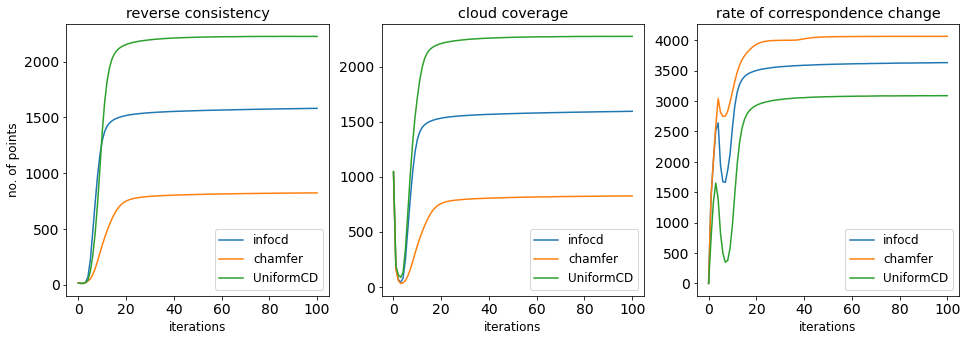

In [54]:
# plot consistency

loss_funcs = ["infocd", "chamfer", "UniformCD"]
unique_list, consistency_list, change_list = [], [], []
for loss_func in loss_funcs:
    with open("sphere/" + loss_func + "_consistency.pkl", "rb") as f:
        consistency, unique, change = pickle.load(f)
        consistency_list.append(consistency)
        unique_list.append(unique)
        change_list.append(change)
print(change_list[0][-1], change_list[1][-1])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plot_dists(axes[0], consistency_list, loss_funcs, title="reverse consistency", 
           ylabel="no. of points", xlabel="iterations", log=False)
plot_dists(axes[1], unique_list, loss_funcs, title="cloud coverage", 
           ylabel="", xlabel="iterations", log=False)
plot_dists(axes[2], change_list, loss_funcs, title="rate of correspondence change", 
           ylabel="", xlabel="iterations", log=False)


In [ ]:
# compare correspondences
#TODO: include consistency in top5 matches?
loss_func = "emd"
with open("sphere/assignments_" + "emd" + ".pkl", "rb") as f:
    emd_assignment = pickle.load(f)

with open("sphere/assignments_" + loss_func + ".pkl", "rb") as f:
    assignment = pickle.load(f)
    
for i, ass in enumerate(assignment):
    #measure_assignment_consistency(ass, emd_assignment[i][0])
    measure_assignment_consistency(ass)
